# Exoplanet-stars detection
In this notebook, we will analyze the light-intensity time series of stars in order to detect whether it has exoplanets or not.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage 
import xgboost as xg
from imblearn.over_sampling import SMOTE #For imbalanced datasets
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline, Pipeline

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train = pd.read_csv('./data/exoTrain.csv')
test =  pd.read_csv('./data/exoTest.csv')

In [354]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


The 'Label' row is the one we are trying to predict, so we must split up the data:

In [4]:
X_train = train.drop('LABEL', axis=1)
y_train = train.LABEL
X_test = test.drop('LABEL', axis=1)
y_test = test.LABEL

Now, let us explore which stars have exoplanets:

In [356]:
z=train[train.LABEL==2]
z

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


## Standard deviations of the Time Series:

In [357]:
St=X_train.std(axis=1)

In [358]:
St.head()

0    160.728487
1     60.011024
2    281.876484
3    103.238723
4    407.121292
dtype: float64

In [359]:
St.max()

1053407.4740101779

In [360]:
St.min()

1.7049357495544919

## Plots of 5 exoplanet stars.
We now graph the light intensities of some stars, just to check whether the difference between exoplanet and non-exoplanet stars can be "seen".

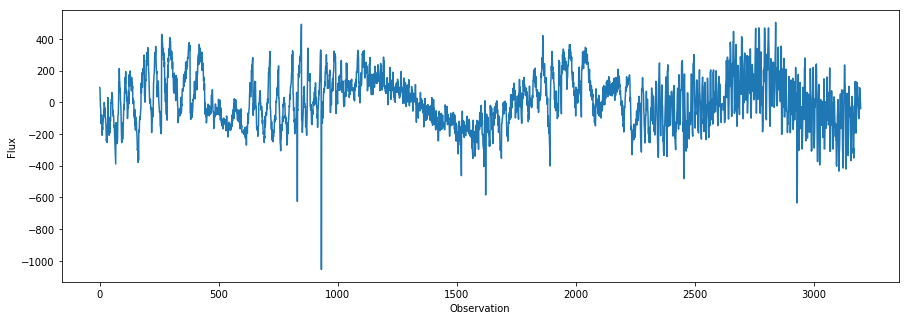

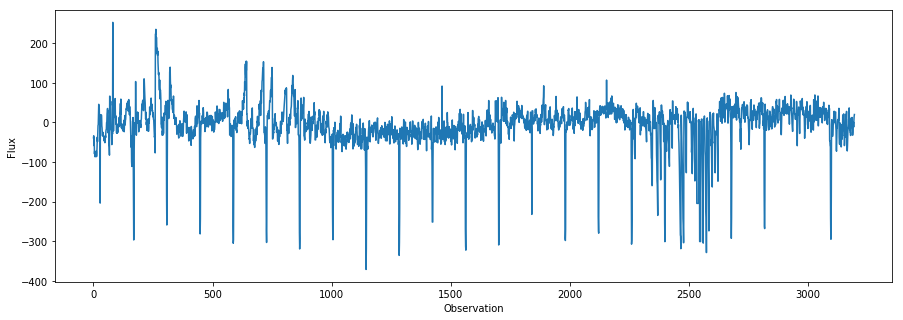

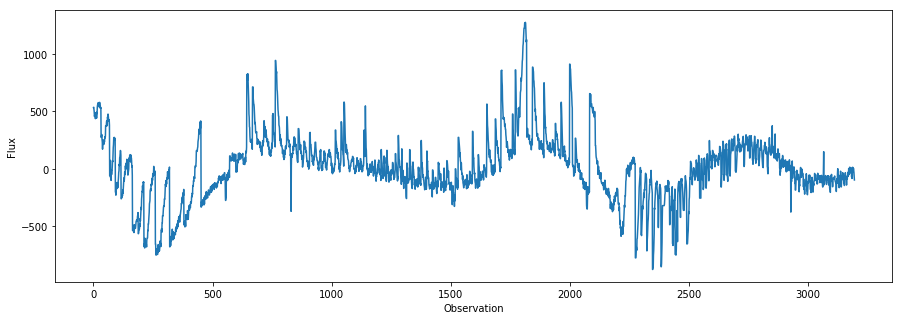

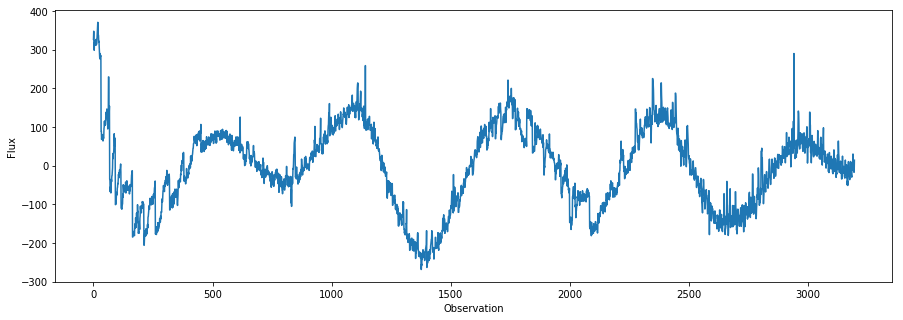

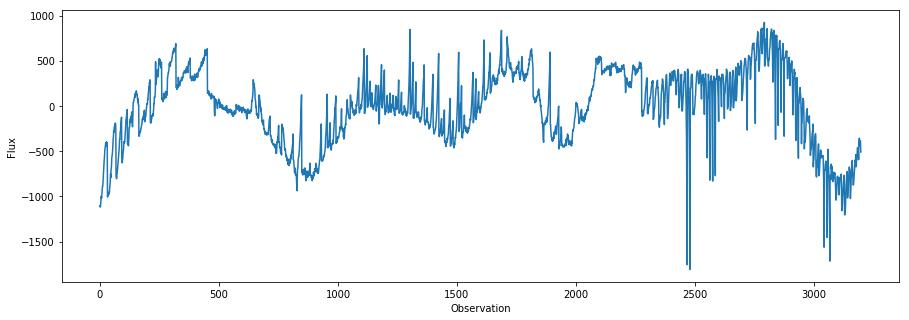

In [361]:
for i in [0,1,2,3,4]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Observation')
    plt.plot(X, Y)
    plt.show()



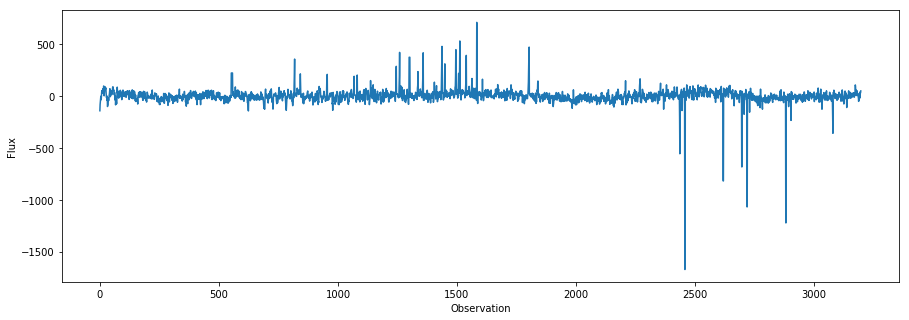

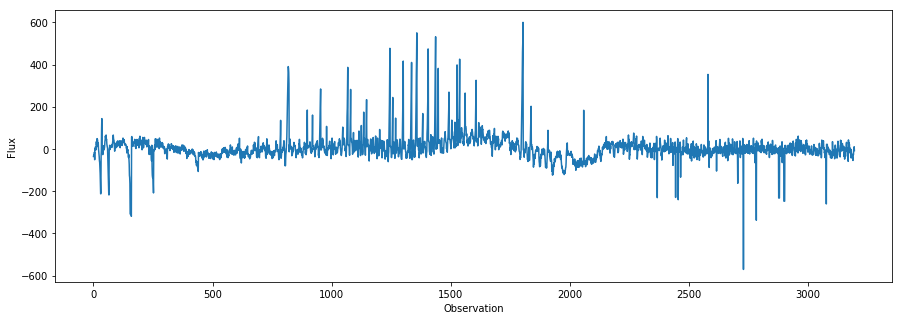

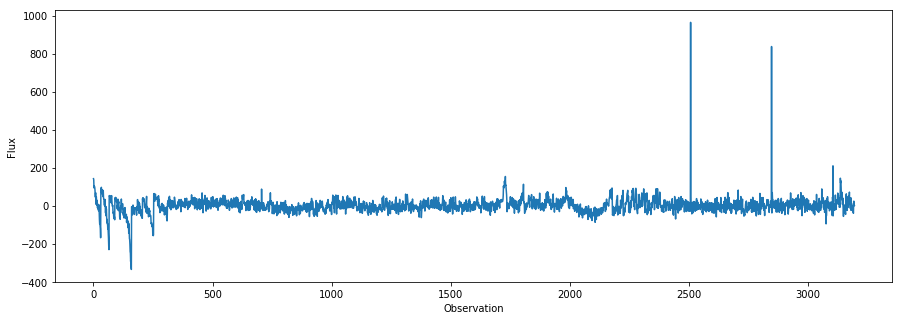

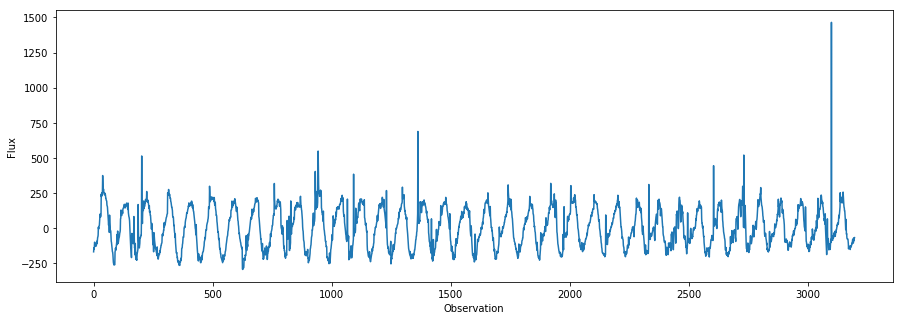

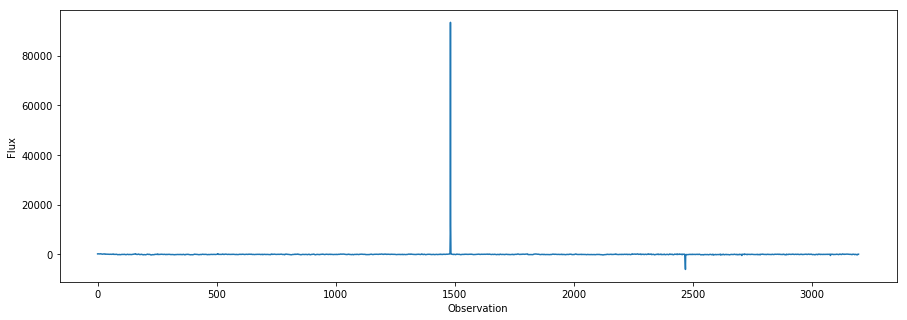

In [362]:
for i in [j for j in range (37,42)]:    
    Y = X_train.iloc[i]
    X = np.arange(len(Y)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Observation')
    plt.plot(X, Y)
    plt.show()

It is not easy to see from the plot whether when a star has exoplanets, let us do more preprocessing.

## Normalization

The light intensities varies a lot between stars, it is better to normalize them.

In [5]:
def normal(X):
    Y= (X-np.mean(X))/(np.max(X)-np.min(X))
    return Y

In [6]:
X_train= X_train.apply(normal,axis=1)


In [7]:
X_test= X_test.apply(normal,axis=1)

## Fourier Transform
Now, we use the fft function (Fast Fourier Transformation) from scipy library, in order to obtain the spectrum of the signals. 

In [8]:
def fourier(X):
    Y = scipy.fft(X, n=X.size)
    return np.abs(Y)

In [9]:
X_train = X_train.apply(fourier,axis=1)

In [10]:
X_test = X_test.apply(fourier,axis=1)

# Plot Fourier Series of the 5 exoplanet stars

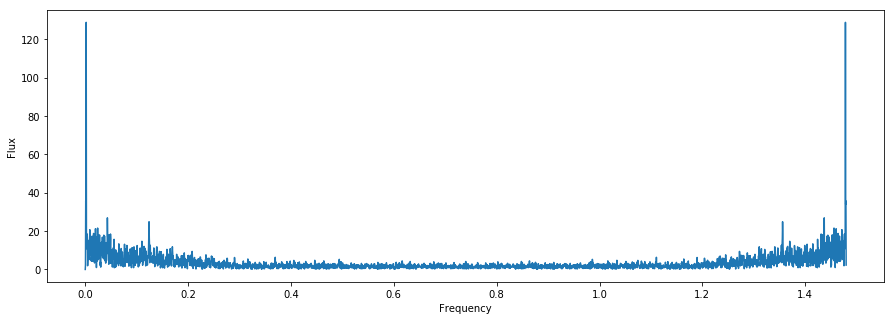

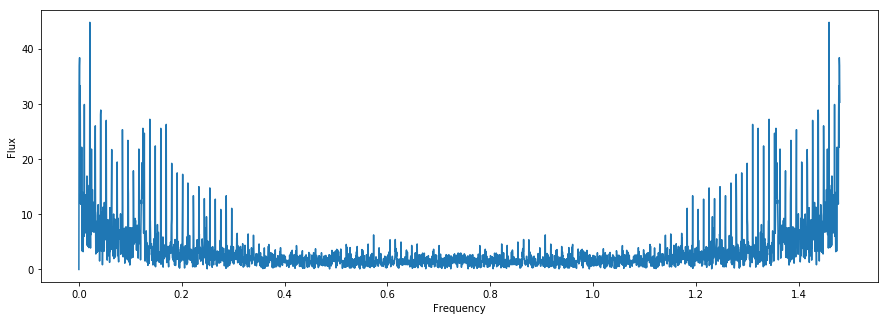

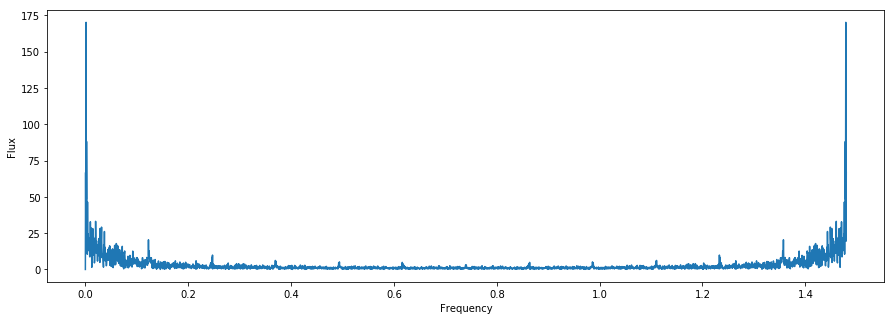

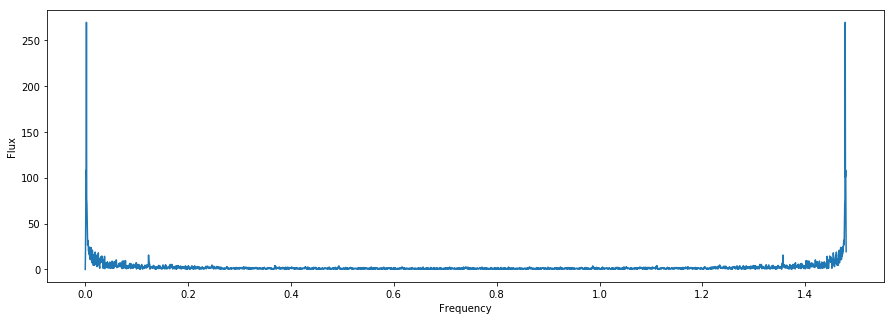

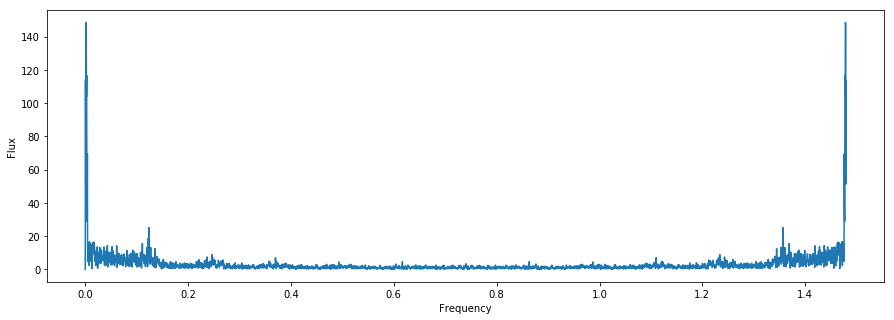

In [369]:
for i in [0,1,2,3,4]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*60.0)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Frequency')
    plt.plot(X, Y)
    plt.show()

# Plot Fourier Series of the 5 non-exoplanet stars


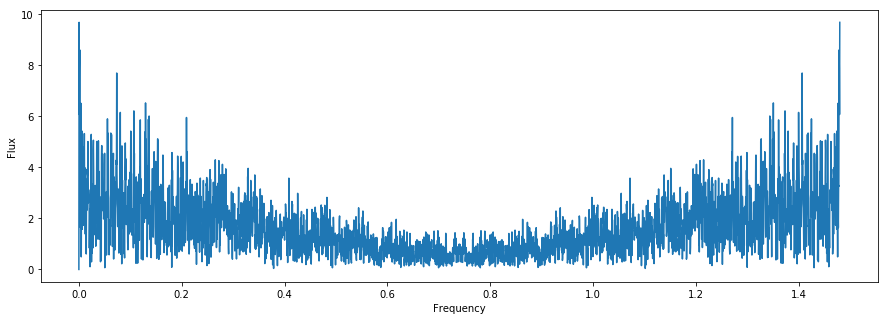

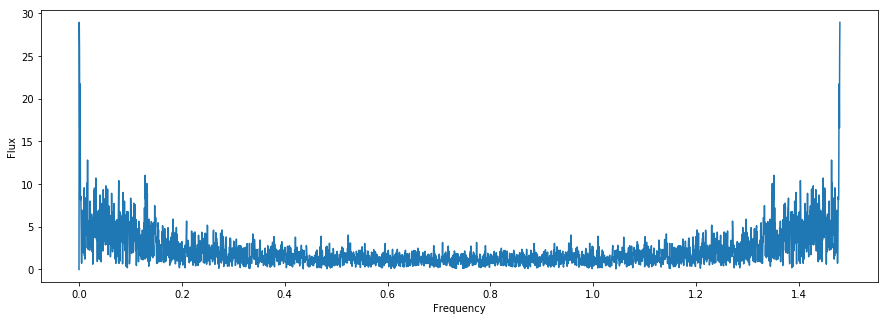

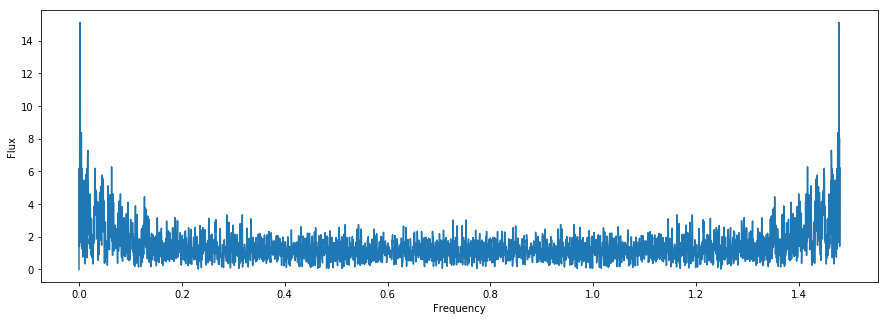

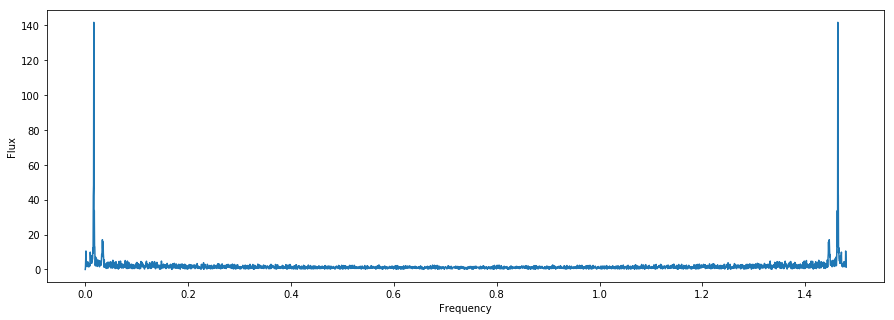

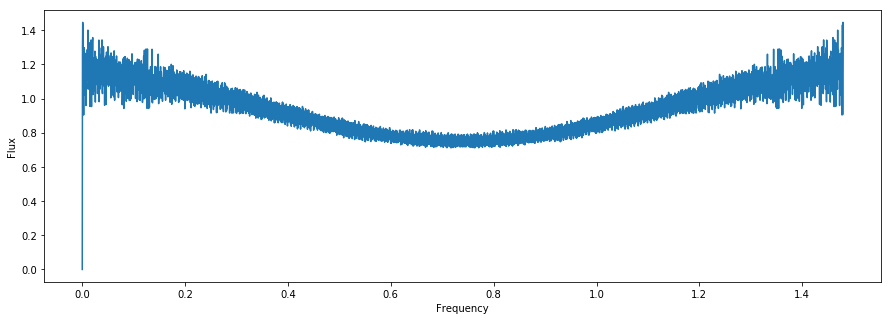

In [370]:
for i in [j for j in range (37,42)]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*60.0)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Frequency')
    plt.plot(X, Y)
    plt.show()

## By symmetry of the Fourier Series, we can remove half of the columns:

In [11]:
X_train = X_train.drop(X_train.columns[1601:], axis=1)

In [12]:
X_test = X_test.drop(X_test.columns[1601:], axis=1)

## Remove High Frequencies:
Since the diming of the flux due to an exostar must have a low frequency on the signal, we creat a new training set by removing the last 100 columns, which represent the higher frequencies:

In [13]:
X_train_h = X_train.drop(X_train.columns[1500:], axis=1)

In [14]:
X_test_h = X_test.drop(X_test.columns[1500:], axis=1)

## Remove Low Frequencies:
Remove the first 100 lowest frequencies.

In [15]:
X_train_l = X_train.drop(X_train.columns[1:100], axis=1)

In [16]:
X_test_l = X_test.drop(X_test.columns[1:100], axis=1)

## Remove High and low Frequencies:

In [17]:
X_train_lh = X_train_h.drop(X_train_h.columns[1:100], axis=1)

In [18]:
X_test_lh = X_test_h.drop(X_test_h.columns[1:100], axis=1)

## Gridsearch multiple models:
We need to compare multiple models and tune their respective parematers, so we will make use of the class found in this webpage:
http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/
We did some modifications in order to apply SMOTE method inside the gridsearch.

In [19]:
sm = SMOTE(ratio = 'auto')

In [20]:
X_train= X_train.as_matrix()
X_test= X_test.as_matrix()

X_train_h= X_train_h.as_matrix()
X_test_h= X_test_h.as_matrix()

X_train_l= X_train_l.as_matrix()
X_test_l= X_test_l.as_matrix()

X_train_lh= X_train_lh.as_matrix()
X_test_lh= X_test_lh.as_matrix()


In [384]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            sm = SMOTE(ratio = 'auto')
            model = self.models[key]
            params = self.params[key]
            pipeline = Pipeline([('sm',sm), ('model',model)]) #create a PIPELINE to apply SMOTE
            kf = StratifiedKFold(n_splits=10)
            gs = GridSearchCV(pipeline, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='min_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores)
                 #'std_score': std(scores), Uncomment later
            }
            return pd.Series({**params,**d}) #Fixed for Python 3
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False) #Fixed for Python 3 sort_values
        
        columns = ['estimator', 'min_score', 'max_score']
         #, 'max_score', 'std_score'] uncomment
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]


In [385]:
models1 = { 
    
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),

}

params1 = { 
    'RandomForestClassifier': { "model__n_estimators": [10, 18, 22],
              "model__max_depth": [3, 5],
              "model__min_samples_split": [15, 20],
              "model__min_samples_leaf": [5, 10, 20], },
    'AdaBoostClassifier':  { "model__n_estimators": [10, 18, 22],
                            },
              
    'XGBClassifier': { 'model__n_estimators': [1000], 'model__learning_rate': [1.0],'model__max_depth':range(3,10,2),
 'model__min_child_weight':range(1,6,2) },

}

In [386]:
f1_scorer = make_scorer(f1_score, pos_label=2)



## GridSearch for the training set with all the columns.

In [387]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train, y_train, scoring=f1_scorer, n_jobs=-1)


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   36.9s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   33.7s remaining:   42.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   50.8s finished


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 18.5min finished


In [388]:
helper.score_summary(sort_by='max_score')

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators
49,XGBClassifier,0.352941,0.736842,0.563261,1,9,3,NaN,NaN,1000
41,XGBClassifier,0.421053,0.7,0.530547,1,3,5,NaN,NaN,1000
47,XGBClassifier,0.555556,0.666667,0.597884,1,7,5,NaN,NaN,1000
39,XGBClassifier,0.470588,0.666667,0.535948,1,3,1,NaN,NaN,1000
45,XGBClassifier,0.470588,0.631579,0.552574,1,7,1,NaN,NaN,1000
44,XGBClassifier,0.526316,0.631579,0.561404,1,5,5,NaN,NaN,1000
46,XGBClassifier,0.470588,0.6,0.542048,1,7,3,NaN,NaN,1000
42,XGBClassifier,0.470588,0.588235,0.509804,1,5,1,NaN,NaN,1000
48,XGBClassifier,0.444444,0.588235,0.501089,1,9,1,NaN,NaN,1000
43,XGBClassifier,0.5,0.588235,0.553221,1,5,3,NaN,NaN,1000


## GridSearch for the training set without the last 100 frequencies.

In [389]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train_h, y_train, scoring=f1_scorer, n_jobs=-1)


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   37.8s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   33.0s remaining:   41.2s


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   49.9s finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 17.8min finished


In [390]:
helper.score_summary(sort_by='max_score')

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators
50,XGBClassifier,0.352941,0.727273,0.53551,1,9,5,NaN,NaN,1000
44,XGBClassifier,0.5,0.631579,0.562378,1,5,5,NaN,NaN,1000
48,XGBClassifier,0.421053,0.588235,0.521614,1,9,1,NaN,NaN,1000
45,XGBClassifier,0.375,0.588235,0.496517,1,7,1,NaN,NaN,1000
43,XGBClassifier,0.444444,0.588235,0.529412,1,5,3,NaN,NaN,1000
39,XGBClassifier,0.380952,0.571429,0.465608,1,3,1,NaN,NaN,1000
49,XGBClassifier,0.3,0.571429,0.475661,1,9,3,NaN,NaN,1000
47,XGBClassifier,0.444444,0.555556,0.508772,1,7,5,NaN,NaN,1000
46,XGBClassifier,0.4,0.555556,0.485185,1,7,3,NaN,NaN,1000
42,XGBClassifier,0.470588,0.555556,0.508715,1,5,1,NaN,NaN,1000


## GridSearch for the training set without the first 100 frequencies.

In [391]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train_l, y_train, scoring=f1_scorer, n_jobs=-1)


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   33.9s finished
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   32.5s remaining:   40.6s


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   47.7s finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 18.3min finished


In [392]:
helper.score_summary(sort_by='max_score')

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators
49,XGBClassifier,0.352941,0.6,0.502832,1,9,3,NaN,NaN,1000
46,XGBClassifier,0.5,0.555556,0.537037,1,7,3,NaN,NaN,1000
41,XGBClassifier,0.173913,0.538462,0.31589,1,3,5,NaN,NaN,1000
42,XGBClassifier,0.4,0.5,0.466667,1,5,1,NaN,NaN,1000
47,XGBClassifier,0.4,0.5,0.440351,1,7,5,NaN,NaN,1000
45,XGBClassifier,0.375,0.5,0.448529,1,7,1,NaN,NaN,1000
43,XGBClassifier,0.235294,0.5,0.356209,1,5,3,NaN,NaN,1000
39,XGBClassifier,0.375,0.5,0.432018,1,3,1,NaN,NaN,1000
44,XGBClassifier,0.421053,0.470588,0.437564,1,5,5,NaN,NaN,1000
13,RandomForestClassifier,0.15,0.461538,0.27792,NaN,3,NaN,20,15,18


## GridSearch for the training set without the first and last 100 frequencies.

In [393]:
helper = EstimatorSelectionHelper(models1, params1)
helper.fit(X_train_lh, y_train, scoring=f1_scorer, n_jobs=-1)


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   35.2s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   32.1s remaining:   40.2s


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   47.3s finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 17.0min finished


In [394]:
helper.score_summary(sort_by='max_score')

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,mean_score,model__learning_rate,model__max_depth,model__min_child_weight,model__min_samples_leaf,model__min_samples_split,model__n_estimators
50,XGBClassifier,0.352941,0.631579,0.468524,1,9,5,NaN,NaN,1000
48,XGBClassifier,0.25,0.588235,0.37465,1,9,1,NaN,NaN,1000
44,XGBClassifier,0.3,0.588235,0.40719,1,5,5,NaN,NaN,1000
42,XGBClassifier,0.375,0.588235,0.477941,1,5,1,NaN,NaN,1000
40,XGBClassifier,0.32,0.588235,0.413856,1,3,3,NaN,NaN,1000
46,XGBClassifier,0.470588,0.526316,0.498968,1,7,3,NaN,NaN,1000
45,XGBClassifier,0.470588,0.526316,0.489164,1,7,1,NaN,NaN,1000
39,XGBClassifier,0.222222,0.526316,0.382846,1,3,1,NaN,NaN,1000
28,RandomForestClassifier,0.266667,0.521739,0.384014,NaN,5,NaN,10,20,18
49,XGBClassifier,0.25,0.5,0.375,1,9,3,NaN,NaN,1000


## Training the algorithms with the highest max-score for each training set.
We use SMOTE on each training set and train the algorithm, with its respective parameters, that got the highest score on the respective training set.

## Complete training set

In [400]:
sm = SMOTE(ratio =1.0,random_state=123 )
X_r, y_r = sm.fit_sample(X_train, y_train)
print (y_train.value_counts(), np.bincount(y_r))

1    5050
2      37
Name: LABEL, dtype: int64 [   0 5050 5050]


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [401]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 3,seed=123)

model.fit(X_r, y_r)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 57.14%


## Training set without last 100 frequencies.

In [403]:
sm = SMOTE(ratio =1.0, random_state=123 )
X_h, y_h = sm.fit_sample(X_train_h, y_train)
print (y_train.value_counts(), np.bincount(y_r))

1    5050
2      37
Name: LABEL, dtype: int64 [   0 5050 5050]


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [404]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 5,seed=123)

model.fit(X_h, y_h)
# make predictions for test data
y_pred = model.predict(X_test_h)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 57.14%


## Training set without the first 100 frequencies

In [406]:
sm = SMOTE(ratio =1.0, random_state=123)
X_l, y_l = sm.fit_sample(X_train_l, y_train)
print (y_train.value_counts(), np.bincount(y_r))

1    5050
2      37
Name: LABEL, dtype: int64 [   0 5050 5050]


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [407]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 3,seed=123)

model.fit(X_l, y_l)
# make predictions for test data
y_pred = model.predict(X_test_l)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 88.89%


## Training set without first and last 100 frequencies

In [409]:
sm = SMOTE(ratio =1.0, random_state=123)
X_lh, y_lh = sm.fit_sample(X_train_lh, y_train)
print (y_train.value_counts(), np.bincount(y_r))

1    5050
2      37
Name: LABEL, dtype: int64 [   0 5050 5050]


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [410]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 5,seed=123)

model.fit(X_lh, y_lh)
# make predictions for test data
y_pred = model.predict(X_test_lh)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 66.67%


## Training the algorithms with the highest mean-score for each training set.
We use SMOTE on each training set and train the algorithm, with its respective parameters, that got the highest mean score on the respective training set.

## Complet Training Set

In [412]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 7, min_child_weight = 5,seed=123)

model.fit(X_r, y_r)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 72.73%


## Training set without last 100 frequencies.

In [413]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 5, min_child_weight = 5,seed=123)

model.fit(X_h, y_h)
# make predictions for test data
y_pred = model.predict(X_test_h)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 57.14%


## Training set without first 100 frequencies.

In [416]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 7, min_child_weight = 3,seed=123)

model.fit(X_l, y_l)
# make predictions for test data
y_pred = model.predict(X_test_l)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 100.00%


Ok!, we must see this. Let's print the predictions:

In [417]:
y_pred

array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

It seems our job is done. But let's run the last case, just for the sake of completeness.

## Training set without first and last 100 frequencies.

In [415]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 7, min_child_weight = 3,seed=123)

model.fit(X_lh, y_lh)
# make predictions for test data
y_pred = model.predict(X_test_lh)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 88.89%


## Validating our model:
Until now, the best model is XGboost, applied on the date without the lowest 100 frequencies, with parameters: max_depth=7, min_child_weight =3. Let us see how it performs by changing the seed ramdomly on the model (and also on SMOTE).

In [21]:
l = np.random.randint(10000, size=10)
l

array([ 932, 3893, 6938, 7414, 5021, 8094, 1165, 6571, 2732, 9478])

In [22]:
for n in l:
    sm = SMOTE(ratio =1.0, random_state= n)
    X_l, y_l = sm.fit_sample(X_train_l, y_train)
#print (y_train.value_counts(), np.bincount(y_r))
    model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 7, min_child_weight = 3,seed=n)
    model.fit(X_l, y_l)
    # make predictions for test data
    y_pred = model.predict(X_test_l)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    f2_score = f1_score(y_test, predictions,pos_label = 2)
    print("f1_score: %.2f%%" % (f2_score * 100.0))

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 66.67%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 75.00%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 75.00%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 75.00%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 90.91%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 88.89%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 88.89%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 88.89%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 88.89%


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


f1_score: 88.89%
